# Sprawozdanie Antoni Kois, Fili Mazur gr.2

In [ ]:
# opcjonalne, zatsnalowanie paczek
%pip install scikit-learn statsmodels

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie danych z pliku
df = pd.read_csv('kois_mazur_projekt_train_data.csv')

# Wyświetlenie pierwszych kilku wierszy danych
print(df.head())

# Sprawdzanie brakujących danych
print(df.isnull().sum())

In [ ]:
# Podstawowe statystyki opisowe

# Wybieramy wszystkie kolumny oprócz 'id'
numeric_cols = df.select_dtypes(include='number').columns

stats = pd.DataFrame({
    'mean':      df[numeric_cols].mean(),
    'std':       df[numeric_cols].std(ddof=1),   # odchylenie standardowe (próba)
    'kurtosis':  df[numeric_cols].kurt(),        # kurtoza (nadmiarowa, 0 = N(0,1))
    'skewness':  df[numeric_cols].skew()         # skośność
})

# Dodanie współczynnika zmienności
stats['coef_var'] = stats['std'] / stats['mean']

print(stats)

In [ ]:
import matplotlib.patches as patches

# Macierz korelacji Pearsona
corr = df[numeric_cols].corr(method="pearson")

print("\nMacierz korelacji (zaokrąglenie do 5 miejsc):\n")
print(corr.round(5))

# Wizualizacja korelacji – mapa cieplna
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr, vmin=-1, vmax=1)  # default colormap

# Opisy osi
ax.set_xticks(range(len(numeric_cols)))
ax.set_xticklabels(numeric_cols, rotation=90, ha="center")
ax.set_yticks(range(len(numeric_cols)))
ax.set_yticklabels(numeric_cols)

# Dodanie wartości liczbowych do komórek
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        value = corr.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')

# Dodanie czerwonej ramki wokół wiersza "Price_euros"
if "Price_euros" in numeric_cols:
    row_index = list(numeric_cols).index("Price_euros")
    rect = patches.Rectangle(
        (-0.5, row_index - 0.5),
        len(numeric_cols),
        1,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

# Pasek kolorów
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Współczynnik korelacji", rotation=90)

plt.title("Macierz korelacji – heatmap")
plt.tight_layout()
plt.show()


- Company - zostawiamy top X kategorii (19 kategorii)
- Product - zbyt dużo kategorii i mniej istotne (618)
- TypeName - mniej istotna zmienna
- Inches - ok
- Ram - ok
- OS - zostawiamy top X kategorii (9 kategorii)
- Weight - ok
- Price_euros - ok
- Screen - 4 kategorie
- ScreenW - ok
- ScreenH - zbyt duża korelacja ze zmienną ScreenW (0.99), więc wyrzucamy
- Touchscreen - ok zmienna 0/1
- IPSpanel - ok zmienna 0/1
- RetinaDisplay - ok zmienna 0/1
- CPU_company - 3 kategorie
- CPU_freq - ok
- CPU_model - zbyt dużo kategorii i mniej istotne (93)
- PrimaryStorage - ok
- SecondaryStorage - ok
- PrimaryStorageType - 4 kategorie
- SecondaryStorageType - mała ilośc danych posaida więc pomijamy
- GPU_company - 3 kategorie
- GPU_model - zbyt dużo kategorii i mniej istotne (110)

In [ ]:
# kolumny do całkowitego usunięcia
DROP_COLS = [
    'Product',
    'TypeName',
    'CPU_model',
    'ScreenH',
    'GPU_model',
    'SecondaryStorageType'
]

# zostawiamy TOP_K a resztę ozancxamy 'Other'
CAT_TOPK_COLS = [
    'Company',
    'OS',
]

# mało kategorii,  zostawiamy wszystkie
CAT_SMALL_COLS = [
    'Screen',
    'CPU_company',
    'PrimaryStorageType',
    'GPU_company'
]

# zmienne 'Yes'/'Not'
BINARY_MAP = {'Yes': 1, 'No': 0}
BIN_COLS = ['Touchscreen', 'IPSpanel', 'RetinaDisplay']


# wszystkie zmienne liczbowe, które zachowujemy
NUM_COLS = [
    'Inches', 'Ram', 'Weight',
    'ScreenW', 'CPU_freq',
    'PrimaryStorage', 'SecondaryStorage'
]

for col in CAT_TOPK_COLS:
    n = df[col].nunique()
    print(f"{col}: {n} unikalnych kategorii")
    
# ile najczęstszych kategorii zostawić
TOP_K = {
    'Company': 6,
    'OS': 5
}

In [ ]:
# Usuwamy zbędne kolumny
df = df.drop(columns=DROP_COLS, errors='ignore')

In [ ]:
# Redukujemy zmienne kategoryczne tak by zawierały TOP_K kategorii a reszta została zmieniona na 'Other', czyli pozbywamy się wartości odstających w zmiennych kategorycznych
for col in CAT_TOPK_COLS:
    vc = df[col].value_counts()          # liczebność każdej kategorii
    top = vc.nlargest(TOP_K[col])        # TOP_K najpopularniejszych
    coverage = top.sum() / len(df) * 100       # % pokrycia obserwacji
    
    # Podmieniamy rzadkie kategorie na 'Other'
    df[col] = df[col].where(df[col].isin(top.index), 'Other')
    
    # Info
    print(f"{col}: TOP {TOP_K[col]} kategorii obejmuje {coverage:.2f}% wierszy "
          f"({top.sum()} z {len(df)})")

In [ ]:
# Zmieniamy zmienne binarne na zero-jedynkowe i dodajemy do kolumn liczbowych
df[BIN_COLS] = df[BIN_COLS].replace(BINARY_MAP).astype(int)

In [ ]:
import numpy as np
from scipy.stats import skew
from pandas.api.types import is_numeric_dtype

# Badanie stacjonarności zmiennych i eliminacja niestacjonarności - pomijamy ponieważ badanie dotyczy danych przekrojowych

# LOGARYTMOWNIE - narazie pomijamy, gdyż może nie być potrzebne
# to_log = [c for c in NUM_COLS if abs(skew(df[c])) > 1]
# print("Logarytmuję:", to_log)

# for c in to_log:
#     df[c + '_log'] = np.log1p(df[c])





# from scipy.stats import skew, boxcox_normmax
# import statsmodels.api as sm
# import statsmodels.stats.api as sms

# # 1. Skew + Box‑Cox
# print("Skew price:", skew(df['Price_euros']))
# print("Box‑Cox λ:", boxcox_normmax(df['Price_euros'] + 1))

# # 2. Model bez log
# model_lin = smf.ols("Price_euros ~ ...", data=df).fit()
# res_lin = model_lin.resid
# print("BP p‑value (lin):", sms.het_breuschpagan(res_lin, model_lin.model.exog)[1])

# # 3. Model z log
# df['Price_euros_log'] = np.log(df['Price_euros'])
# model_log = smf.ols("Price_euros_log ~ ...", data=df).fit()
# res_log = model_log.resid
# print("BP p‑value (log):", sms.het_breuschpagan(res_log, model_log.model.exog)[1])

In [ ]:
# Wartości odstające

# zwraca (dolna_granica, górna_granica) wg. reguły k*IQR.
def iqr_bounds(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - k * iqr, q3 + k * iqr



# Zwraca DataFrame z liczbą i % outlierów w każdej kolumnie.
# Niczego nie zmienia w danych. Do sprawdzenia ile wartości odstających
def iqr_report(df: pd.DataFrame, cols, k=1.5):
    rows = []
    for c in cols:
        low, high = iqr_bounds(df[c], k)
        n_out = (~df[c].between(low, high)).sum()
        rows.append([c, n_out, 100 * n_out / len(df), low, high])

    rep = pd.DataFrame(rows,
                       columns=['kolumna', 'odstających', '%', 'dolna', 'górna'])
    rep = rep.sort_values('%', ascending=False)
    return rep



# Zwraca nowy DataFrame bez wierszy uznanych za odstające w podanych kolumnach.
def iqr_filter(df: pd.DataFrame, cols, k=1.5):
    mask = pd.Series(True, index=df.index)
    for c in cols:
        low, high = iqr_bounds(df[c], k)
        mask &= df[c].between(low, high)
    return df[mask].copy()

iqr_report(df, NUM_COLS)


Po przeanalizowaniu informacji odstających, uzjanemy na początku nie usuwać zadnych żadnych wartości odstających,
gdyż dla większości nich np. jak dla `ScreenW` 80 % laptopów ma dokładnie 1920px wysokości. Każda inna wartość jest traktowana jako “odstająca”, a można też patrzeć na tą zmienną jako kategoryczną.
To samo zjawisko można zauważyć dla kolumn `PrimaryStorage`, `Ram`, `SecondaryStorage`.
Na usunięcie odstających wartości decydujemy się dla kolumn `Weight`, `Inches`.
W dalszej części budowy modelu być może zdecydujemy się na usunięcię z innych pojedynczych zmiennych odstające wartości.

In [ ]:
before = len(df)
df_clean = iqr_filter(df, ['Weight', 'Inches'])

print(f"\nUsunięto {before - len(df_clean)} obserwacji "
      f"({100*(before - len(df_clean))/before:.2f} %).")

In [ ]:
import statsmodels.formula.api as smf

categorical_cols = CAT_TOPK_COLS + CAT_SMALL_COLS
# zmienne oznaczone w formule C(...) są autoamtycznie przetwarzane na zmienne zero-jedynkowe dla modelu ekoenometrycznego z pominięciem pierwszej kategorii jako bazowej.
rhs_terms = NUM_COLS + BIN_COLS + [f"C({c})" for c in categorical_cols]

formula = "Price_euros ~ " + " + ".join(rhs_terms)
print("\nFormuła OLS:\n", formula, "\n")

ols_model = smf.ols(formula=formula, data=df_clean).fit()

print(ols_model.summary())

### Metoda krokowa wsteczna

In [ ]:
import statsmodels.formula.api as smf
import numpy as np


def backward_stepwise_selection(data, target_col, predictors, significance_level=0.05, verbose=True):

    
    current_vars = predictors.copy()
    selection_history = []
    
    if verbose:
        print("=== METODA KROKOWA WSTECZNA ===")
        print(f"Liczba zmiennych początkowych: {len(current_vars)}")
        print(f"Poziom istotności: {significance_level}")
        print("-" * 50)
    
    step = 0
    max_steps = len(predictors) + 5
    
    while len(current_vars) > 0 and step < max_steps:
        step += 1
        
        formula = f"{target_col} ~ " + " + ".join(current_vars)
        
        try:
            model = smf.ols(formula, data=data).fit()
            
            p_values = model.pvalues.drop('Intercept', errors='ignore')
            
            if len(p_values) == 0:
                if verbose:
                    print(f"Krok {step}: Brak zmiennych do analizy")
                break
            
            var_groups = {}
            
            for param_name, p_val in p_values.items():
                base_var = None
                
                for var in current_vars:
                    if var.startswith('C(') and var.endswith(')'):
                        cat_name = var[2:-1]
                        if (param_name.startswith(f"C({cat_name})[") or 
                            param_name == f"C({cat_name})"):
                            base_var = var
                            break
                    else:

                        if param_name == var:
                            base_var = var
                            break
                

                if base_var is None:
                    for var in current_vars:
                        if var in param_name or param_name in var:
                            base_var = var
                            break
                
                if base_var:
                    if base_var not in var_groups:
                        var_groups[base_var] = []
                    var_groups[base_var].append(p_val)
            

            unassigned_vars = set(current_vars) - set(var_groups.keys())
            if unassigned_vars and verbose:
                print(f"  Ostrzeżenie: Nie przypisano parametrów dla zmiennych: {unassigned_vars}")
            
            worst_var = None
            max_min_p_value = 0
            
            for var, p_vals in var_groups.items():
                if len(p_vals) > 0:
                    min_p_val = min(p_vals)
                    if min_p_val > max_min_p_value:
                        max_min_p_value = min_p_val
                        worst_var = var
            
            if worst_var is None:
                if verbose:
                    print(f"Krok {step}: Nie można znaleźć zmiennej do usunięcia")
                break
            
            if verbose:
                print(f"Krok {step}:")
                print(f"  Liczba zmiennych: {len(current_vars)}")
                print(f"  R²: {model.rsquared:.4f}")
                print(f"  Adj R²: {model.rsquared_adj:.4f}")
                print(f"  AIC: {model.aic:.2f}")
                print(f"  Kandydat do usunięcia: {worst_var} (min p-value: {max_min_p_value:.4f})")
            

            step_info = {
                'step': step,
                'variables': current_vars.copy(),
                'n_vars': len(current_vars),
                'r_squared': model.rsquared,
                'adj_r_squared': model.rsquared_adj,
                'aic': model.aic,
                'worst_var': worst_var,
                'worst_p_value': max_min_p_value,
                'action': None
            }
            

            if max_min_p_value > significance_level and len(current_vars) > 1:
                current_vars = [v for v in current_vars if v != worst_var]
                step_info['action'] = f'Usunięto {worst_var}'
                if verbose:
                    print(f"  → Usuwam zmienną: {worst_var}")
                    print()
            else:
                step_info['action'] = 'Zatrzymano - wszystkie zmienne istotne'
                if verbose:
                    if max_min_p_value <= significance_level:
                        print(f"  → Wszystkie zmienne są istotne statystycznie")
                    else:
                        print(f"  → Zatrzymano - pozostała tylko jedna zmienna")
                    print()
                selection_history.append(step_info)
                break
                
            selection_history.append(step_info)
            
        except Exception as e:
            if verbose:
                print(f"Błąd w kroku {step}: {e}")
                print(f"Aktualna formuła: {formula}")
                print(f"Aktualne zmienne: {current_vars}")
            break
    
    final_model = None
    if len(current_vars) > 0:
        try:
            final_formula = f"{target_col} ~ " + " + ".join(current_vars)
            final_model = smf.ols(final_formula, data=data).fit()
            
            if verbose:
                print("=" * 50)
                print("WYNIKI METODY KROKOWEJ WSTECZNEJ:")
                print(f"Wybrane zmienne ({len(current_vars)}):")
                
                for var in current_vars:
                    if var.startswith('C(') and var.endswith(')'):
                        cat_name = var[2:-1]
                        cat_params = [p for p in final_model.pvalues.index 
                                    if (p.startswith(f"C({cat_name})[") or p == f"C({cat_name})") 
                                    and p != 'Intercept']
                        if cat_params:
                            min_p = min([final_model.pvalues[p] for p in cat_params])
                            print(f"  - {var} (min p-value: {min_p:.4f})")
                        else:
                            print(f"  - {var} (p-value: brak danych)")
                    else:
                        p_val = final_model.pvalues.get(var, np.nan)
                        print(f"  - {var} (p-value: {p_val:.4f})")
                
                print(f"\nOstateczny model:")
                print(f"  R²: {final_model.rsquared:.4f}")
                print(f"  Adj R²: {final_model.rsquared_adj:.4f}")
                print(f"  AIC: {final_model.aic:.2f}")
                print(f"  F-statistic: {final_model.fvalue:.2f}")
                print(f"  Prob(F-statistic): {final_model.f_pvalue:.2e}")
        
        except Exception as e:
            if verbose:
                print(f"Błąd przy tworzeniu ostatecznego modelu: {e}")
    
    return current_vars, final_model, selection_history


selected_vars, final_model, history = backward_stepwise_selection(
    data=df_clean.copy(),
    target_col='Price_euros',
    predictors=rhs_terms,
    significance_level=0.05,
    verbose=False
)

if final_model is not None:
    print("\n" + "="*60)
    print("SZCZEGÓŁOWE WYNIKI OSTATECZNEGO MODELU:")
    print("="*60)
    print(final_model.summary())
else:
    print("Nie udało się utworzyć ostatecznego modelu.")

TESTY DIAGNOSTYCZNE MODELU
NORMALNOŚĆ RESZT
Wielkość próby: 938
✗ Testy normalności nie powiodły się: too many values to unpack (expected 2)

TESTY HETEROSKEDASTYCZNOŚCI
Test Breusch-Pagan:
  Statystyka LM: 167.4685
  p-wartość: 4.7324e-23
  Wynik: Heteroskedastyczny

Test White:
  Statystyka LM: 590.6040
  p-wartość: 3.4902e-45
  Wynik: Heteroskedastyczny


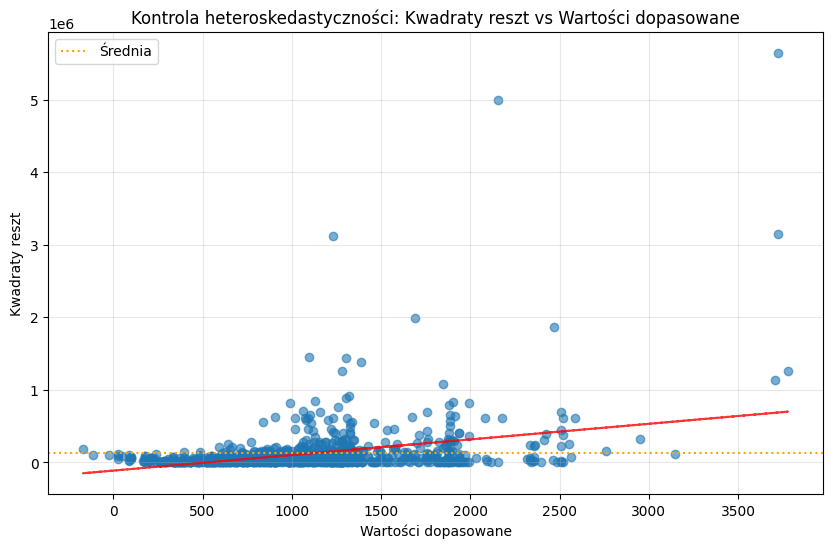

✓ Testy heteroskedastyczności ukończone

KONTROLA WIELOKOLINIOWOŚCI (VIF)
Analizowane zmienne: ['Inches', 'Ram', 'ScreenW', 'CPU_freq', 'RetinaDisplay']

Wyniki VIF:
------------------------------
Inches              :     1.09 - OK
Ram                 :     1.45 - OK
ScreenW             :     1.40 - OK
CPU_freq            :     1.15 - OK
RetinaDisplay       :     1.05 - OK

Interpretacja:
  VIF < 5:   Brak problemów z wielokoliniowością
  VIF 5-10:  Umiarkowana wielokoliniowość
  VIF > 10:  Wysoka wielokoliniowość (problematyczna)


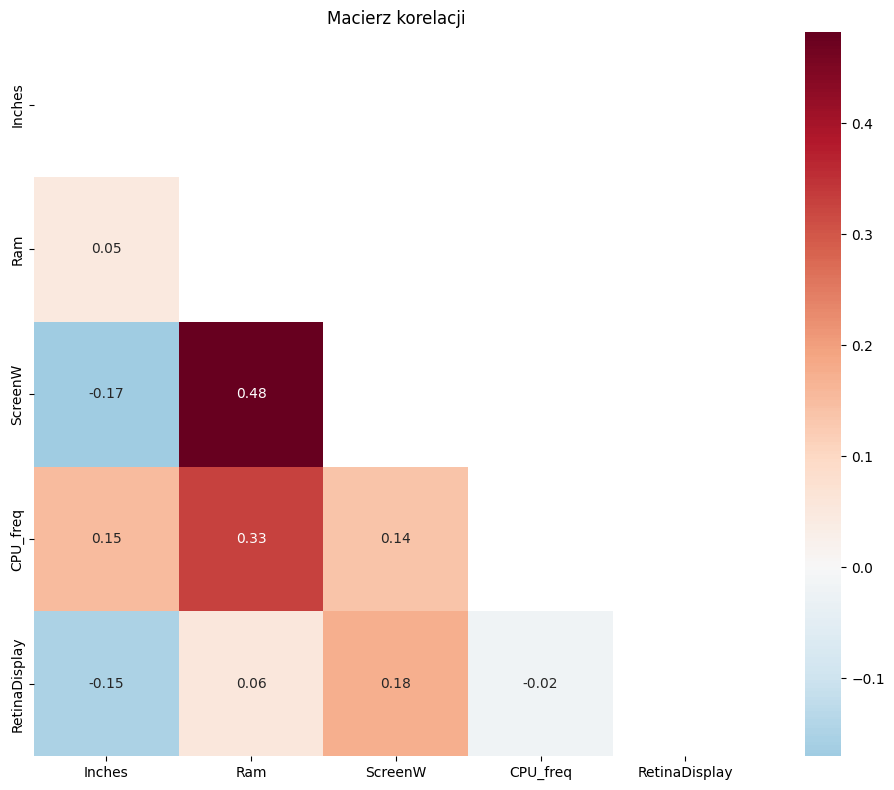

✓ Kontrola wielokoliniowości ukończona

TEST STABILNOŚCI PARAMETRÓW
Grupa 1: 656 obserwacji
Grupa 2: 282 obserwacji

Wyniki testu Chow:
  Statystyka F: 1.1678
  p-wartość: 2.4384e-01
  Wynik: Stabilne parametry

Portównanie parametrów:
                                 Model_pełny    Grupa_1    Grupa_2   Różnica
Intercept                         -1367.6391 -1411.4155 -1464.8489   53.4335
C(Company)[T.Asus]                  139.9106   145.8601   108.3872   37.4729
C(Company)[T.Dell]                  195.2555   220.3445   140.4641   79.8804
C(Company)[T.HP]                    232.4740   224.6478   303.6357  -78.9879
C(Company)[T.Lenovo]                190.3709   161.6188   244.8745  -83.2557
C(Company)[T.Other]                 260.0097   244.9469   282.6914  -37.7444
C(Company)[T.Toshiba]               218.0749   225.1581   230.9949   -5.8368
C(OS)[T.Linux]                     -210.3188  -207.9089  -176.4146  -31.4943
C(OS)[T.No OS]                     -345.4892  -311.9831  -324.4288   12

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
import seaborn as sns
import numpy as np


def check_residual_normality(model, show_plots=True):
    """Sprawdza czy reszty mają rozkład normalny przy użyciu wielu testów."""
    
    print("="*50)
    print("NORMALNOŚĆ RESZT")
    print("="*50)
    
    residuals = model.resid
    n = len(residuals)
    print(f"Wielkość próby: {n}")
    
    # Test Jarque-Bera - działa dobrze dla większych próbek
    jb_stat, jb_p = jarque_bera(residuals)
    print(f"\nTest Jarque-Bera:")
    print(f"  Statystyka: {jb_stat:.4f}")
    print(f"  p-wartość: {jb_p:.4e}")
    print(f"  Wynik: {'Normalny' if jb_p > 0.05 else 'Nie normalny'}")
    
    # Shapiro-Wilk dla mniejszych próbek
    if n <= 5000:
        try:
            sw_result = stats.shapiro(residuals)
            sw_stat, sw_p = sw_result.statistic, sw_result.pvalue
            print(f"\nTest Shapiro-Wilk:")
            print(f"  Statystyka: {sw_stat:.4f}")
            print(f"  p-wartość: {sw_p:.4e}")
            print(f"  Wynik: {'Normalny' if sw_p > 0.05 else 'Nie normalny'}")
        except:
            # Starsze wersje scipy
            sw_stat, sw_p = stats.shapiro(residuals)
            print(f"\nTest Shapiro-Wilk:")
            print(f"  Statystyka: {sw_stat:.4f}")
            print(f"  p-wartość: {sw_p:.4e}")
            print(f"  Wynik: {'Normalny' if sw_p > 0.05 else 'Nie normalny'}")
    
    # Test Kołmogorowa-Smirnowa
    standardized_resid = (residuals - residuals.mean()) / residuals.std()
    ks_stat, ks_p = stats.kstest(standardized_resid, 'norm')
    print(f"\nTest Kołmogorowa-Smirnowa:")
    print(f"  Statystyka: {ks_stat:.4f}")
    print(f"  p-wartość: {ks_p:.4e}")
    print(f"  Wynik: {'Normalny' if ks_p > 0.05 else 'Nie normalny'}")
    
    # Podstawowe statystyki
    print(f"\nStatystyki reszt:")
    print(f"  Średnia: {residuals.mean():.6f}")
    print(f"  Odch. std.: {residuals.std():.4f}")
    print(f"  Skośność: {stats.skew(residuals):.4f}")
    print(f"  Kurtoza: {stats.kurtosis(residuals):.4f}")
    
    if show_plots:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
        
        # Histogram z nałożonym rozkładem normalnym
        ax1.hist(residuals, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
        x = np.linspace(residuals.min(), residuals.max(), 100)
        ax1.plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-', linewidth=2)
        ax1.set_title('Rozkład reszt')
        ax1.set_xlabel('Reszty')
        ax1.set_ylabel('Gęstość')
        
        # Wykres Q-Q
        stats.probplot(residuals, dist="norm", plot=ax2)
        ax2.set_title('Wykres Q-Q')
        ax2.grid(True, alpha=0.3)
        
        # Reszty vs wartości dopasowane
        fitted = model.fittedvalues
        ax3.scatter(fitted, residuals, alpha=0.6, color='blue')
        ax3.axhline(y=0, color='red', linestyle='--')
        ax3.set_xlabel('Wartości dopasowane')
        ax3.set_ylabel('Reszty')
        ax3.set_title('Reszty vs Wartości dopasowane')
        
        # Wykres lokalizacji skali
        sqrt_abs_resid = np.sqrt(np.abs(residuals))
        ax4.scatter(fitted, sqrt_abs_resid, alpha=0.6, color='green')
        ax4.set_xlabel('Wartości dopasowane')
        ax4.set_ylabel('√|Reszty|')
        ax4.set_title('Wykres lokalizacji skali')
        
        plt.tight_layout()
        plt.show()
    
    return {'jarque_bera': (jb_stat, jb_p), 'shapiro': (sw_stat, sw_p) if n <= 5000 else None}


def check_heteroscedasticity(model):
    """Test na heteroskedastyczność przy użyciu testów Breusch-Pagan i White."""
    
    print("\n" + "="*50)
    print("TESTY HETEROSKEDASTYCZNOŚCI")
    print("="*50)
    
    try:
        X = model.model.exog
        residuals = model.resid
        
        # Test Breusch-Pagan
        bp_stat, bp_p, bp_f, bp_fp = het_breuschpagan(residuals, X)
        print(f"Test Breusch-Pagan:")
        print(f"  Statystyka LM: {bp_stat:.4f}")
        print(f"  p-wartość: {bp_p:.4e}")
        print(f"  Wynik: {'Homoskedastyczny' if bp_p > 0.05 else 'Heteroskedastyczny'}")
        
        # Test White
        try:
            white_stat, white_p, white_f, white_fp = het_white(residuals, X)
            print(f"\nTest White:")
            print(f"  Statystyka LM: {white_stat:.4f}")
            print(f"  p-wartość: {white_p:.4e}")
            print(f"  Wynik: {'Homoskedastyczny' if white_p > 0.05 else 'Heteroskedastyczny'}")
        except:
            print("\nTest White: Niepowodzenie (niewystarczające dane lub problemy numeryczne)")
            white_stat, white_p = np.nan, np.nan
        
        # Wizualna kontrola
        fitted = model.fittedvalues
        squared_resid = residuals**2
        
        plt.figure(figsize=(10, 6))
        plt.scatter(fitted, squared_resid, alpha=0.6)
        plt.xlabel('Wartości dopasowane')
        plt.ylabel('Kwadraty reszt')
        plt.title('Kontrola heteroskedastyczności: Kwadraty reszt vs Wartości dopasowane')
        
        # Dodaj linię trendu
        z = np.polyfit(fitted, squared_resid, 1)
        p = np.poly1d(z)
        plt.plot(fitted, p(fitted), "r--", alpha=0.8)
        plt.axhline(y=squared_resid.mean(), color='orange', linestyle=':', label='Średnia')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return {'breusch_pagan': (bp_stat, bp_p), 'white': (white_stat, white_p)}
        
    except Exception as e:
        print(f"Błąd w testach heteroskedastyczności: {e}")
        return None


def check_multicollinearity(data, variables, target='Price_euros'):
    """Oblicza VIF do wykrywania problemów z wielokoliniowością."""
    
    print("\n" + "="*50)
    print("KONTROLA WIELOKOLINIOWOŚCI (VIF)")
    print("="*50)
    
    # Pobierz tylko zmienne numeryczne
    numeric_vars = []
    for var in variables:
        if var != target and not var.startswith('C('):
            if var in data.columns and pd.api.types.is_numeric_dtype(data[var]):
                numeric_vars.append(var)
    
    if len(numeric_vars) < 2:
        print("Potrzeba co najmniej 2 zmiennych numerycznych do obliczenia VIF")
        return None
    
    print(f"Analizowane zmienne: {numeric_vars}")
    
    # Przygotuj dane
    vif_data = data[numeric_vars].dropna()
    
    # Usuń zmienne stałe
    for col in vif_data.columns:
        if vif_data[col].nunique() <= 1:
            print(f"Usuwanie zmiennej stałej: {col}")
            vif_data = vif_data.drop(columns=[col])
    
    if vif_data.shape[1] < 2:
        print("Za mało zmiennych po usunięciu stałych")
        return None
    
    # Dodaj stałą do obliczenia VIF
    X = sm.add_constant(vif_data)
    
    # Oblicz VIF
    vif_results = []
    print("\nWyniki VIF:")
    print("-" * 30)
    
    for i, col in enumerate(vif_data.columns):
        vif = variance_inflation_factor(X.values, i + 1)
        
        if np.isinf(vif):
            status = "Idealna koliniowość!"
        elif vif > 10:
            status = "Wysoka koliniowość"
        elif vif > 5:
            status = "Umiarkowana koliniowość"
        else:
            status = "OK"
        
        vif_results.append([col, vif, status])
        print(f"{col:20s}: {vif:8.2f} - {status}")
    
    print("\nInterpretacja:")
    print("  VIF < 5:   Brak problemów z wielokoliniowością")
    print("  VIF 5-10:  Umiarkowana wielokoliniowość")
    print("  VIF > 10:  Wysoka wielokoliniowość (problematyczna)")
    
    # Mapa ciepła korelacji
    corr_matrix = vif_data.corr()
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.2f', mask=mask)
    plt.title('Macierz korelacji')
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(vif_results, columns=['Zmienna', 'VIF', 'Status'])


def stability_test(data, formula, split_point=0.7, split_var=None):
    """Test Chow dla stabilności parametrów."""
    
    print("\n" + "="*50)
    print("TEST STABILNOŚCI PARAMETRÓW")
    print("="*50)
    
    import statsmodels.formula.api as smf
    
    n = len(data)
    
    if split_var:
        # Podział według wartości zmiennej
        mask = data[split_var] <= split_point
        group1 = data[mask]
        group2 = data[~mask]
    else:
        # Podział według proporcji
        split_idx = int(n * split_point)
        shuffled_data = data.sample(frac=1, random_state=42)
        group1 = shuffled_data.iloc[:split_idx]
        group2 = shuffled_data.iloc[split_idx:]
    
    print(f"Grupa 1: {len(group1)} obserwacji")
    print(f"Grupa 2: {len(group2)} obserwacji")
    
    if len(group1) < 20 or len(group2) < 20:
        print("Ostrzeżenie: Małe rozmiary próbek mogą wpłynąć na wiarygodność testu")
    
    # Dopasuj modele
    full_model = smf.ols(formula, data=data).fit()
    model1 = smf.ols(formula, data=group1).fit()
    model2 = smf.ols(formula, data=group2).fit()
    
    # Oblicz statystykę Chow
    rss_full = sum(full_model.resid**2)
    rss_split = sum(model1.resid**2) + sum(model2.resid**2)
    
    k = full_model.df_model + 1  # liczba parametrów
    f_stat = ((rss_full - rss_split) / k) / (rss_split / (n - 2*k))
    
    df1, df2 = k, n - 2*k
    p_value = 1 - stats.f.cdf(f_stat, df1, df2)
    
    print(f"\nWyniki testu Chow:")
    print(f"  Statystyka F: {f_stat:.4f}")
    print(f"  p-wartość: {p_value:.4e}")
    print(f"  Wynik: {'Stabilne parametry' if p_value > 0.05 else 'Niestabilne parametry'}")
    
    # Porównaj współczynniki
    print(f"\nPortównanie parametrów:")
    comparison = pd.DataFrame({
        'Model_pełny': full_model.params,
        'Grupa_1': model1.params,
        'Grupa_2': model2.params,
        'Różnica': model1.params - model2.params
    })
    print(comparison.round(4))
    
    return {'f_stat': f_stat, 'p_value': p_value, 'comparison': comparison}


def run_diagnostics(model, data, variables, formula=None):
    """Uruchom kompleksową diagnostykę modelu."""
    
    print("TESTY DIAGNOSTYCZNE MODELU")
    print("="*60)
    
    results = {}
    
    # Normalność
    try:
        results['normality'] = check_residual_normality(model)
        print("✓ Testy normalności ukończone")
    except Exception as e:
        print(f"✗ Testy normalności nie powiodły się: {e}")
        results['normality'] = None
    
    # Heteroskedastyczność
    try:
        results['heteroscedasticity'] = check_heteroscedasticity(model)
        print("✓ Testy heteroskedastyczności ukończone")
    except Exception as e:
        print(f"✗ Testy heteroskedastyczności nie powiodły się: {e}")
        results['heteroscedasticity'] = None
    
    # Wielokoliniowość
    try:
        results['vif'] = check_multicollinearity(data, variables)
        print("✓ Kontrola wielokoliniowości ukończona")
    except Exception as e:
        print(f"✗ Kontrola wielokoliniowości nie powiodła się: {e}")
        results['vif'] = None
    
    # Stabilność (jeśli podano formułę)
    if formula:
        try:
            results['stability'] = stability_test(data, formula)
            print("✓ Test stabilności ukończony")
        except Exception as e:
            print(f"✗ Test stabilności nie powiódł się: {e}")
            results['stability'] = None
    
    # Podsumowanie
    print("\n" + "="*60)
    print("PODSUMOWANIE DIAGNOSTYKI")
    print("="*60)
    
    if results['normality']:
        jb_p = results['normality']['jarque_bera'][1]
        print(f"Normalność: {'✓ ZALICZONY' if jb_p > 0.05 else '✗ NIEZALICZONY'} (p={jb_p:.4e})")
    
    if results['heteroscedasticity']:
        bp_p = results['heteroscedasticity']['breusch_pagan'][1]
        print(f"Homoskedastyczność: {'✓ ZALICZONY' if bp_p > 0.05 else '✗ NIEZALICZONY'} (p={bp_p:.4e})")
    
    if results['vif'] is not None:
        max_vif = results['vif']['VIF'].max()
        print(f"Wielokoliniowość: {'✓ ZALICZONY' if max_vif < 5 else '⚠ OSTRZEŻENIE' if max_vif < 10 else '✗ NIEZALICZONY'} (max VIF={max_vif:.2f})")
    
    if results['stability']:
        stab_p = results['stability']['p_value']
        print(f"Stabilność parametrów: {'✓ ZALICZONY' if stab_p > 0.05 else '✗ NIEZALICZONY'} (p={stab_p:.4e})")
    
    return results


# Przykład użycia:
results = run_diagnostics(final_model, df_clean, selected_vars, formula)